In [1]:
pip install tensorflow keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import re
import string
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Function to clean text with handling of negations
def clean_text(sentences):
    stopwords_list = stopwords.words('english')
    text = sentences.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    
    # Handling negations
    text = re.sub(r'\bnot\s(\w+)', r'not_\1', text)
    return text

# Load the dataset
data = pd.read_csv('kaggle_train.csv')

# Handle missing values in the 'comment' column
data['comment'].fillna('', inplace=True)

# Clean the comments in the dataset
data['cleaned_comment'] = data['comment'].map(lambda x: clean_text(x) if isinstance(x, str) else '')

# Tokenization and padding
vocab_size = 15000  # Increased vocab size
embedding_dim = 200  # Increased embedding dimension
max_length = 80  # Increased max length
padding_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['cleaned_comment'].tolist())

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_comment'].tolist())
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type)

# Prepare labels
labels = data['label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

# Load GloVe word embeddings
embeddings_index = {}
with open('glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model using GloVe embeddings with all suggested improvements
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),  # Reduced Conv1D filters
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.02))),  # Reduced LSTM units and added L2 regularization
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),  # Reduced Dense layer units and added L2 regularization
    tf.keras.layers.Dropout(0.6),  # Retained Dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model with a smaller learning rate
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with a smaller batch size and increased validation split
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.3, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

# Generate a classification report
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()
classification_report_output = classification_report(y_test, y_pred_labels, target_names=['Not Sarcastic', 'Sarcastic'])

print("Classification Report:")
print(classification_report_output)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Shubham\anaconda4\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 989s 61ms/step - accuracy: 0.6179 - loss: 2.1293 - val_accuracy: 0.6831 - val_loss: 0.5972
Epoch 2/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 857s 54ms/step - accuracy: 0.6975 - loss: 0.5865 - val_accuracy: 0.6859 - val_loss: 0.5902
Epoch 3/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 897s 56ms/step - accuracy: 0.7204 - loss: 0.5606 - val_accuracy: 0.6935 - val_loss: 0.5837
Epoch 4/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 1023s 64ms/step - accuracy: 0.7440 - loss: 0.5316 - val_accuracy: 0.6893 - val_loss: 0.5918
Epoch 5/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 957s 60ms/step - accuracy: 0.7648 - loss: 0.5018 - val_accuracy: 0.6869 - val_loss: 0.6166
Epoch 6/15
15913/15913 ━━━━━━━━━━━━━━━━━━━━ 969s 61ms/step - accuracy: 0.7852 - loss: 0.4701 - val_accuracy: 0.6810 - val_loss: 0.6324
5684/5684 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - accuracy: 0.6900 - loss: 0.5875
Test Accuracy: 0.6909143924713135
Test Loss: 0.5865253806114197
5684/5684 ━━━━━━━━━━━━━━━━━━━━ 89s 15ms/step
C

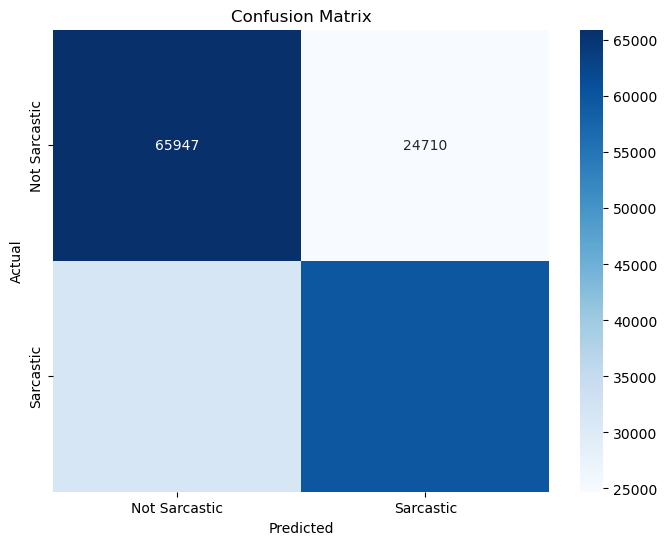

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


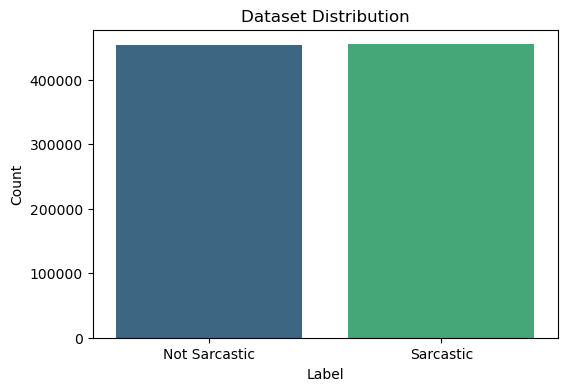

In [4]:
# Print dataset distribution
distribution = data['label'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=distribution.index, y=distribution.values, palette='viridis')
plt.title('Dataset Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Sarcastic', 'Sarcastic'])
plt.show()


In [5]:
# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 80, 200)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 76, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 19, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 19, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,225,477 (39.01 MB)

 Trainable params: 3,408,321 (13.00 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,816,644 (26.00 MB)

In [ ]:
def preprocess_and_predict(comment):
    # Preprocess the input comment
    cleaned_comment = clean_text(comment)
    
    # Tokenize and pad the comment
    sequence = tokenizer.texts_to_sequences([cleaned_comment])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type)
    
    # Make a prediction using the model
    prediction = model.predict(padded_sequence)
    
    # Interpret the prediction
    if prediction[0][0] > 0.5:
        return "Sarcastic"
    else:
        return "Not Sarcastic"

# Example usage for new input with the trained model
new_comment = "This is a sample comment for prediction."
prediction_result = preprocess_and_predict(new_comment)
print(f"Prediction for new comment: {prediction_result}")

# Interactive input for user to check if a comment is sarcastic
while True:
    user_input = input("Enter a comment to check if it is sarcastic or 'exit' to quit: ")
    if user_input.lower() == 'exit':
        break
    print(f"Prediction: {preprocess_and_predict(user_input)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction for new comment: Not Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  I am batman


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Not Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  Oh god, this is gonna be fun!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction: Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  How much money do you have? Are you Ambani's son?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: Not Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  It's raining cats and dogs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Not Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  You are a dumbo


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction: Not Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  I am so happy I have to wait for another 24 hours!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Sarcastic


Enter a comment to check if it is sarcastic or 'exit' to quit:  It is raining cats and dogs!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: Not Sarcastic
